In [3]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///E:/Studia/Inzynierka/csgo-analysis/notebooks/mlruns/1
Tags: {}
Lifecycle_stage: active


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, GRU, Dense, Masking, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Wczytanie danych

In [5]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [6]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['demoId', 'roundNum'])
df

FileNotFoundError: [Errno 2] No such file or directory: 'data/ESTA_states_prepared.parquet'

In [ ]:
df.info()

In [ ]:
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()
y

## Podział

In [ ]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
for i in range(10):
    print(i)
    np.random.seed(i)
    samples_indexes = [values[np.random.randint(1, values.size)]
                      for key, values in demo_indexes.items()]
    len(samples_indexes)

    X = df.drop(['demoId', 'roundNum'], axis='columns').iloc[samples_indexes]
    y = y.iloc[samples_indexes]
    X.shape, y.shape

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1
    X_train.shape, X_val.shape, X_test.shape

    cols = X_train.columns.tolist()
    scaler = StandardScaler()
    norm_train = scaler.fit_transform(X_train)
    norm_valid = scaler.transform(X_val)
    norm_test = scaler.transform(X_test)

    os.makedirs("model_deep", exist_ok=True)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=30,
        verbose=0,
        mode='min',
        baseline=None,
        restore_best_weights=True,
    )

    model_checkpoint_callback = ModelCheckpoint(
        filepath="model_deep/multi_layer.tf",
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    logger = CSVLogger(
        "model_deep/perceptron_log.csv", separator=',', append=True
    )

    model = Sequential()
    model.add(InputLayer(input_shape=(norm_train.shape[-1])))
    model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

    model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
    history = model.fit(x=norm_train,
                        y=y_train,
                        batch_size=2048,
                        epochs=1000,
                        validation_data=(norm_valid, y_val),
                        callbacks=[early_stopping, model_checkpoint_callback, logger],
                        verbose=0)

    run_name = f"Multi Layer Perceptron Complicated - ESTA #{i}"
    additional_description = "Multi Layer Perceptron"
    with mlflow.start_run(run_name=run_name, description=additional_description) as run:
            mlflow.log_param("X_train.shape", norm_train.shape)
            mlflow.log_param("X_test.shape", norm_test.shape)

            y_proba = model.predict(norm_test)
            y_true = y_test
            features_names = cols
            metrics = {}
            for threshold in np.arange(0.1, 1, 0.05):
                y_pred = (y_proba >= threshold).astype(int)
                metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
                metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
                metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
                metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
            metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
            metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
            mlflow.log_metrics(metrics)

            if os.path.exists('artifacts'):
                shutil.rmtree('artifacts')
                os.makedirs('artifacts')

            if os.path.exists('models'):
                shutil.rmtree('models')
                os.makedirs('models')

            with open("artifacts/features.txt", 'w') as f:
                f.write(str(features_names))

            model.save('models/model.tf')

            roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
            roc_plot.figure_.savefig('artifacts/roc_auc.png')
            plt.show()

            calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
            calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
            plt.show()

            mlflow.log_artifacts("artifacts", artifact_path="plots_data")
            mlflow.log_artifacts("models", artifact_path="model")

    test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
    past = test_df['filename'].str.startswith("IEM-Katowice")
    future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
    test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
    test_y = test_y.squeeze()
    test_df.shape

    test_set = test_df.drop("filename", axis="columns")
    test_set = scaler.fit_transform(test_set)
    test_set.shape

    results = []
    y_true = test_y
    y_pred = model.predict(test_set)
    results = {
            "LogLoss (all)": log_loss(y_true, y_pred),
            "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
            "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
            "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
            "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
            "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
    }
    results

# Większy sampling

## Podział

In [19]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
np.random.seed(25)
how_many = 10
samples_indexes = {key: [values[np.random.randint(1, values.size)]
                   for i in range(how_many)]
                      for key, values in demo_indexes.items()}
len(samples_indexes)

41074

In [20]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
test_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i not in train_ind:
        test_indexes = np.concatenate((test_indexes, samples_indexes[key]))

test_indexes.shape

(82150,)

In [21]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(train_ind, size=int(0.875*train_ind.size), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((287510,), (123230,))

In [22]:
X = df.drop(['demoId', 'roundNum'], axis='columns')
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()

In [23]:
y.value_counts()

1    3875902
0    3588396
Name: winningSideCT, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], y.iloc[train_indexes], y.iloc[test_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape, X_test.shape

((287510, 99), (123230, 99), (82150, 99))

In [25]:
cols = X_train.columns.tolist()
scaler = StandardScaler()
norm_train = scaler.fit_transform(X_train)
norm_valid = scaler.transform(X_val)
norm_test = scaler.transform(X_test)

In [26]:
os.makedirs("model_deep", exist_ok=True)

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model_deep/multi_layer.tf",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

logger = CSVLogger(
    "model_deep/perceptron_log.csv", separator=',', append=True
)

In [28]:
model = Sequential()
model.add(InputLayer(input_shape=(norm_train.shape[-1])))
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2'))

model.compile(optimizer="Adam", loss=BinaryCrossentropy(), metrics=[BinaryAccuracy(), AUC()])
history = model.fit(x=norm_train,
                    y=y_train,
                    batch_size=2048,
                    epochs=1000,
                    validation_data=(norm_valid, y_val),
                    callbacks=[early_stopping, model_checkpoint_callback, logger])

Epoch 1/1000
141/141 [==============================] - 1s 6ms/step - loss: 1.5609 - binary_accuracy: 0.7788 - auc_1: 0.8746 - val_loss: 0.4870 - val_binary_accuracy: 0.7817 - val_auc_1: 0.8766
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 2/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.4674 - binary_accuracy: 0.7833 - auc_1: 0.8793 - val_loss: 0.4681 - val_binary_accuracy: 0.7806 - val_auc_1: 0.8763
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 3/1000
141/141 [==============================] - 1s 4ms/step - loss: 0.4623 - binary_accuracy: 0.7824 - auc_1: 0.8786 - val_loss: 0.4666 - val_binary_accuracy: 0.7798 - val_auc_1: 0.8750
INFO:tensorflow:Assets written to: model_deep\multi_layer.tf\assets
Epoch 4/1000
141/141 [==============================] - 1s 5ms/step - loss: 0.4606 - binary_accuracy: 0.7826 - auc_1: 0.8787 - val_loss: 0.4657 - val_binary_accuracy: 0.7808 - val_auc_1: 0.8766
INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: models/model.tf\assets


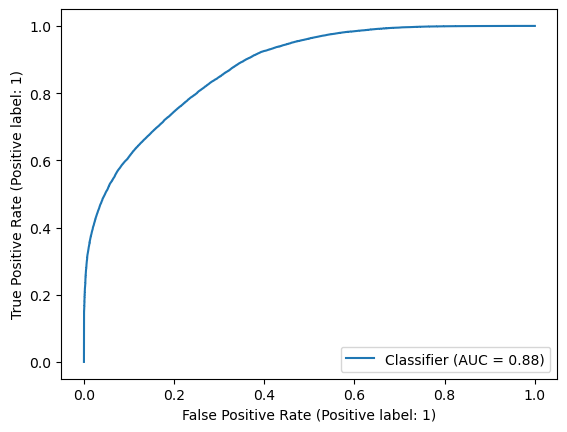

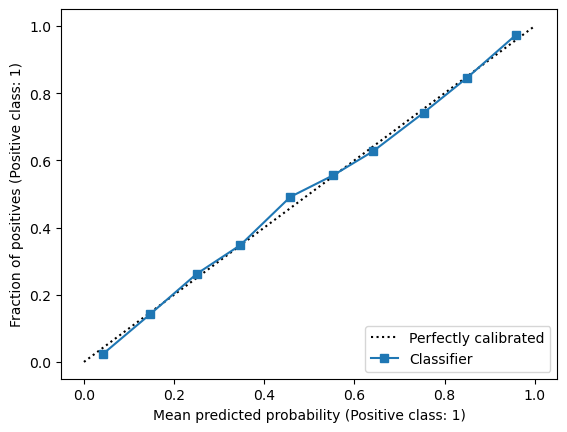

In [29]:
run_name = "Multi Layer Perceptron Complicated - ESTA 10 samples"
additional_description = "Multi Layer Perceptron"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_param("X_train.shape", norm_train.shape)
        mlflow.log_param("X_test.shape", norm_test.shape)

        y_proba = model.predict(norm_test)
        y_true = y_test
        features_names = cols
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        if os.path.exists('artifacts'):
            shutil.rmtree('artifacts')
            os.makedirs('artifacts')
        
        if os.path.exists('models'):
            shutil.rmtree('models')
            os.makedirs('models')
            
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        model.save('models/model.tf')

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.png')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.png')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [30]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [31]:
test_set = test_df.drop("filename", axis="columns")
test_set = scaler.fit_transform(test_set)
test_set.shape

(620392, 99)

In [32]:
results = []
y_true = test_y
y_pred = model.predict(test_set)
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.473205117094989,
 'LogLoss (future)': 0.47463231206482837,
 'LogLoss (past)': 0.47187434550688545,
 'AUC-ROC (all)': 0.8493992476034509,
 'AUC-ROC (future)': 0.8518639130642098,
 'AUC-ROC (past)': 0.8464011245553233}